In [2]:
import pandas as pd
import numpy as np
from coffea import util
import itertools
import os, sys
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import mplhep as hep
hep.style.use("CMS")

sys.path.append('../python/')
from functions import loadCoffeaFile, getLabelMap, getCoffeaFilenames, plotBackgroundEstimate, getHist


## analysis categories

In [4]:
IOVs = ['2016']

# analysis categories #

label_dict = loadCoffeaFile()['analysisCategories']

label_to_int_dict = {label: i for i, label in label_dict.items()}

signal_cats = [ i for label, i in label_to_int_dict.items() if '2t' in label]
pretag_cats = [ i for label, i in label_to_int_dict.items() if 'pre' in label]
antitag_cats = [ i for label, i in label_to_int_dict.items() if 'at' in label]




In [5]:
label_dict

{0: 'at0bcen',
 1: 'at0bfwd',
 2: 'at1bcen',
 3: 'at1bfwd',
 4: 'at2bcen',
 5: 'at2bfwd',
 6: 'pret0bcen',
 7: 'pret0bfwd',
 8: 'pret1bcen',
 9: 'pret1bfwd',
 10: 'pret2bcen',
 11: 'pret2bfwd',
 12: '2t0bcen',
 13: '2t0bfwd',
 14: '2t1bcen',
 15: '2t1bfwd',
 16: '2t2bcen',
 17: '2t2bfwd'}

## scale factors and IOV

In [6]:
IOVs = ['2016']

lumi = {
    "2016APV": 19800.,
    "2016": 16120., #35920 - 19800
    "2016all": 35920,
    "2017": 41530.,
    "2018": 59740.
}

t_BR = 0.6741
ttbar_BR = 0.4544 #PDG 2019
ttbar_xs1 = 831.76 * (0.09210) #pb For ttbar mass from 700 to 1000
ttbar_xs2 = 831.76 * (0.02474) #pb For ttbar mass from 1000 to Inf
toptag_sf = 0.9
toptag_kf = 1.0 #0.7
qcd_xs = 13700000.0 #pb From https://cms-gen-dev.cern.ch/xsdb



## save plots

In [7]:
directories = [
    'images/png/closureTestQCD/2016all',
    'images/png/closureTestQCD/2016APV',
    'images/png/closureTestQCD/2016',
    'images/png/closureTestQCD/2017',
    'images/png/closureTestQCD/2018',
    'images/pdf/closureTestQCD/2016all',
    'images/pdf/closureTestQCD/2016APV',
    'images/pdf/closureTestQCD/2016',
    'images/pdf/closureTestQCD/2017',
    'images/pdf/closureTestQCD/2018',
]


for path in directories:
    if not os.path.exists(path):
        os.makedirs(path)

## coffea files

In [8]:
tagger='DeepAK8 top tagger'
# tagger='CMS top tagger'


coffeaFiles = getCoffeaFilenames()

# coffeaFiles



# Background Estimate 
### with msd cut

/opt/conda/lib/python3.8/site-packages/hist/basehist.py:324: UserWarning: List indexing selection is experimental. Removed bins are not placed in overflow.
  return super().__getitem__(self._index_transform(index))


Text(1, 0, '')

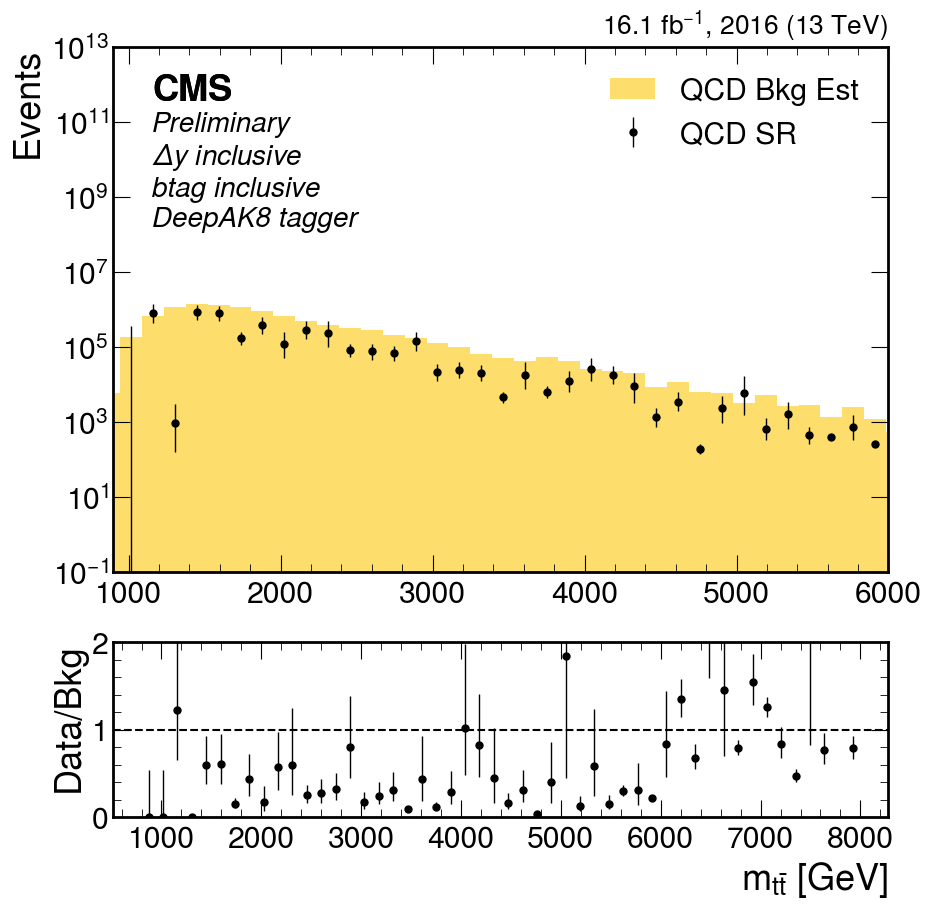

In [9]:
IOV = '2016'

fig, (ax1, ax2) = plt.subplots(nrows=2, height_ratios=[3, 1])

sig = util.load(coffeaFiles['QCD']['unweighted'][IOV])
bkg = util.load(coffeaFiles['QCD']['weighted'][IOV])

qcdsf = {
    'sig': lumi[IOV] * qcd_xs / sig['cutflow']['sumw'],
    'bkg': lumi[IOV] * qcd_xs / bkg['cutflow']['sumw'],
}

hsig = sig['ttbarmass'][{'anacat':signal_cats}][{'anacat':sum, 'systematic':sum}] * qcdsf['sig']
hbkg = bkg['ttbarmass'][{'anacat':pretag_cats}][{'anacat':sum, 'systematic':sum}] * qcdsf['bkg']


hep.cms.label('', data=True, lumi='{0:0.1f}'.format(lumi[IOV]/1000), year=IOV, loc=2, fontsize=20, ax=ax1)
hep.cms.text('Preliminary'+'\n'+r'$\Delta y$ inclusive'+'\n'+r'btag inclusive''\n'+r'DeepAK8 tagger', loc=2, fontsize=20, ax=ax1)

hep.histplot(hsig, histtype='errorbar', color='black', label='QCD SR', ax=ax1)
hep.histplot(hbkg, histtype='fill', color='xkcd:pale gold', label='QCD Bkg Est', ax=ax1)


ratio_plot =  hsig / hbkg.values()
hep.histplot(ratio_plot, ax=ax2, histtype='errorbar', color='black')
ax2.set_ylim(0,2)
ax2.axhline(1, color='black', ls='--')
ax2.set_ylabel('Data/Bkg')


ax1.legend()
ax1.set_ylabel('Events')
ax1.set_yscale('log')
ax1.set_ylim(1e-1, 1e13)
ax1.set_xlim(900,6000)
ax1.set_xlabel('')


# Transfer Function

In [10]:
# fit N events from CR to N events from SR


# loose to fail | pretag to antitag

def rlf(x, mt, p0, p1):
    
    return x*(p0 + p1 * mt)


# pass to loose | signal to pretag

def rtl(x, mt, mtt, p2, p3, p4, p5):
    
    return x * (p2 + p3 * mt + p4 * mt * mt) * (p5 * mtt) 
    

In [11]:
qcd = loadCoffeaFile()


mtt_vs_mt = getHist('mtt_vs_mt', 'JetHT', False, '2016', sum_axes=[], integrate_axes={})



h2dsr = mtt_vs_mt[{'anacat':signal_cats}][{'anacat':sum}]
h2dcr = mtt_vs_mt[{'anacat':antitag_cats}][{'anacat':sum}]
h2dpr = mtt_vs_mt[{'anacat':pretag_cats}][{'anacat':sum}]





qcdsf = lumi[IOV] * qcd_xs / qcd['cutflow']['sumw']

hsig_mtt = h2dsr[{'jetmass':sum}]# * qcdsf
hbkg_mtt = h2dcr[{'jetmass':sum}]# * qcdsf


Nsr = h2dsr.values()#*qcdsf
Ncr = h2dcr.values()#*qcdsf
Npr = h2dpr.values()#*qcdsf





/opt/conda/lib/python3.8/site-packages/hist/basehist.py:324: UserWarning: List indexing selection is experimental. Removed bins are not placed in overflow.
  return super().__getitem__(self._index_transform(index))


## signal region $N_{events}$  / pretag region $N_{events}$

for transfer function $n_{tight} = n_{loose} * R$

/opt/conda/lib/python3.8/site-packages/boost_histogram/_internal/view.py:190: RuntimeWarning: invalid value encountered in divide
  ufunc(
/opt/conda/lib/python3.8/site-packages/boost_histogram/_internal/view.py:196: RuntimeWarning: invalid value encountered in divide
  ufunc(


ColormeshArtists(pcolormesh=<matplotlib.collections.QuadMesh object at 0x7fbe5eaa5160>, cbar=<matplotlib.colorbar.Colorbar object at 0x7fbe5eaa5550>, text=[])

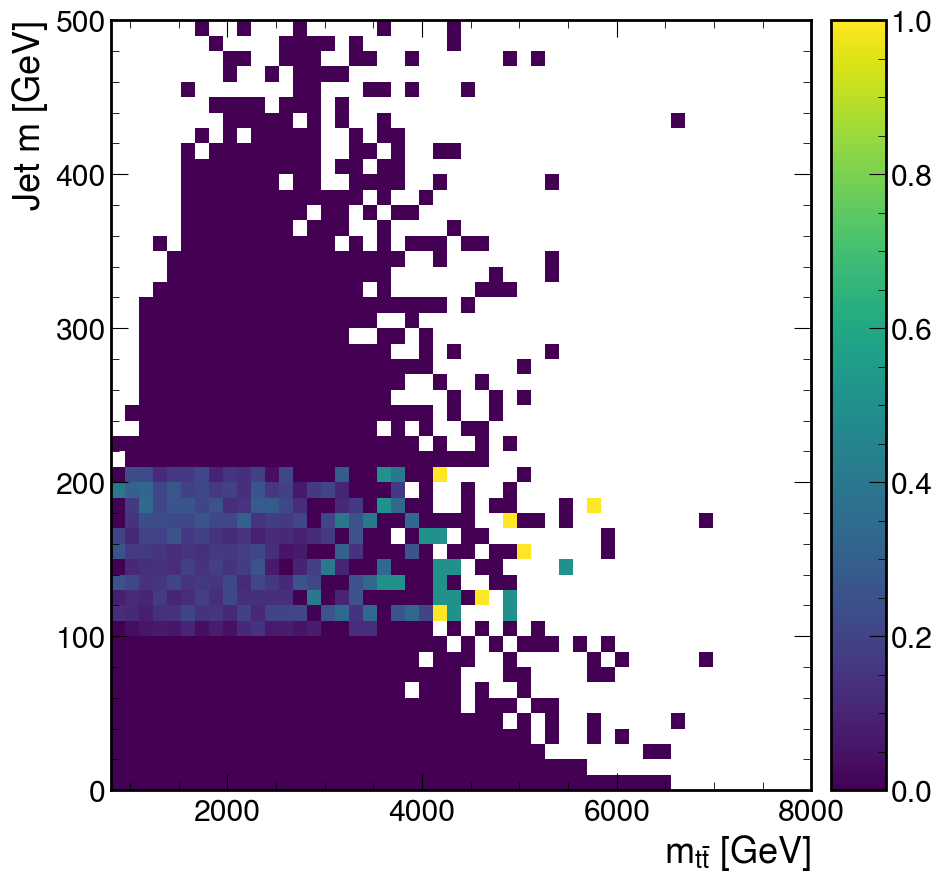

In [12]:
(h2dsr/h2dpr.values()).plot2d()

## pretag region $N_{events}$  / antitag region $N_{events}$

for transfer function $n_{loose} = n_{fail} * R$

/opt/conda/lib/python3.8/site-packages/boost_histogram/_internal/view.py:190: RuntimeWarning: divide by zero encountered in divide
  ufunc(
/opt/conda/lib/python3.8/site-packages/boost_histogram/_internal/view.py:196: RuntimeWarning: divide by zero encountered in divide
  ufunc(


ColormeshArtists(pcolormesh=<matplotlib.collections.QuadMesh object at 0x7fbe63672e80>, cbar=<matplotlib.colorbar.Colorbar object at 0x7fbe61c62dc0>, text=[])

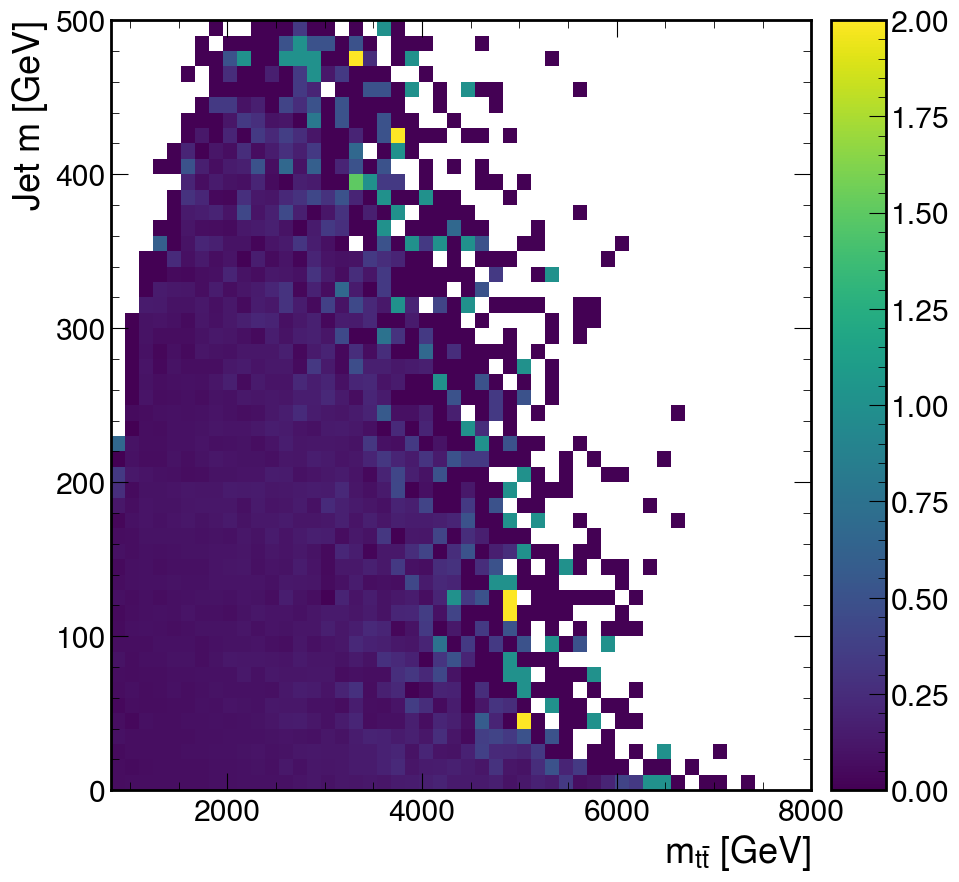

In [13]:
(h2dpr/h2dcr.values()).plot2d()

In [14]:

bins_mt = h2dsr.axes['jetmass'].edges[:-1]
bins_mtt = h2dsr.axes['ttbarmass'].edges[:-1]


mtt, mt = np.meshgrid(bins_mtt, bins_mt)



# flatten arrays for fitting
f_mt  =  mt.flatten()
f_mtt = mtt.flatten()
f_nsr = Nsr.flatten()
f_ncr = Ncr.flatten()
f_npr = Npr.flatten()


In [15]:
# loose to fail | pretag to antitag


y = np.where(f_ncr > 0, f_npr/f_ncr, 0)

popt, pcov = curve_fit(lambda x, p0, p1: rlf(x, f_mt, p0, p1), 
                       f_ncr, 
                       f_npr, 
                       p0=[1,1])


p0, p1 = popt

f_rlf = rlf(np.ones_like(Ncr), mt, p0, p1)


/tmp/ipykernel_4112/1749341785.py:4: RuntimeWarning: divide by zero encountered in divide
  y = np.where(f_ncr > 0, f_npr/f_ncr, 0)
/tmp/ipykernel_4112/1749341785.py:4: RuntimeWarning: invalid value encountered in divide
  y = np.where(f_ncr > 0, f_npr/f_ncr, 0)


In [16]:

# pass to loose | signal to pretag


y = np.where(f_npr > 0, f_nsr/f_npr, 0)





popt, pcov = curve_fit(lambda x, p2, p3, p4, p5: rtl(x, f_mt, f_mtt, p2, p3, p4, p5), 
                       f_npr,
                       f_nsr,
                       p0=[1,1,1,1], bounds=[-10,10])


p2, p3, p4, p5 = popt

f_rtl = rtl(np.ones_like(Ncr), mt, mtt, p2, p3, p4, p5)

/tmp/ipykernel_4112/3229433568.py:4: RuntimeWarning: invalid value encountered in divide
  y = np.where(f_npr > 0, f_nsr/f_npr, 0)


## transfer function plots

/tmp/ipykernel_4112/2966468612.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('jet')
/tmp/ipykernel_4112/2966468612.py:30: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax1.dist = 12


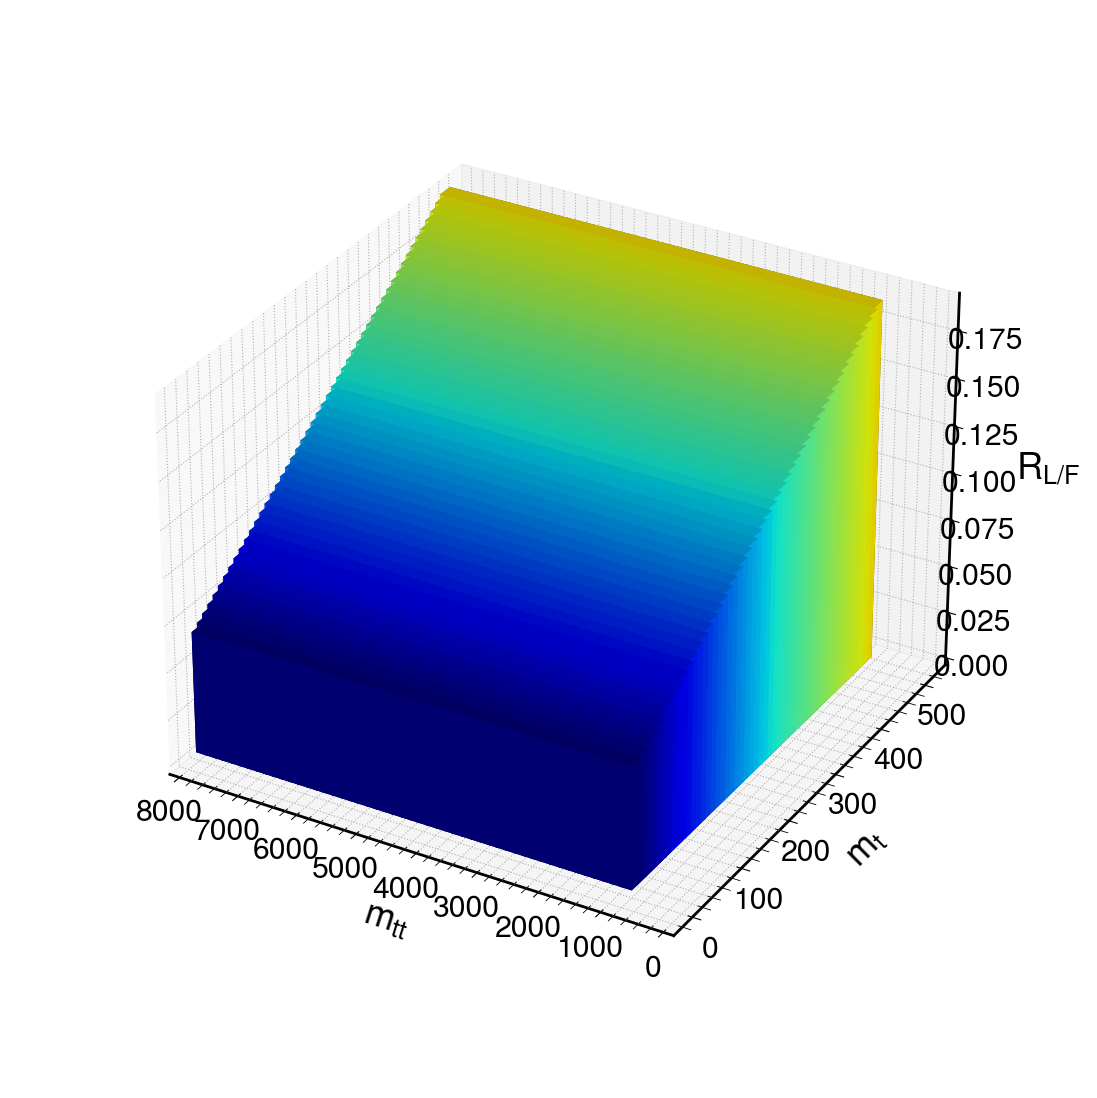

In [17]:
fig = plt.figure(figsize=(20, 14))
ax1 = fig.add_subplot(projection='3d')

x = mtt.flatten() #f_mtt
y = mt.flatten() #f_mt
z = f_rlf.flatten()

bottom = np.zeros_like(z) #mtt_vs_mt.values()[1]

dx = 200
dy = 20

cmap = plt.cm.get_cmap('jet')
hmax = np.max(z)
hmin = np.min(z)

# hmin = 0.0

rgba = [cmap((k-hmin)/hmax) for k in z] 

ax1.bar3d(x, y, bottom, dx, dy, z, color=rgba)
ax1.set_xlim(8000,0)


ax1.zaxis.set_rotate_label(False)
ax1.set_xlabel(r'$m_{tt}$', labelpad=20, loc='right')
ax1.set_ylabel(r'$m_t$', labelpad=20)
ax1.set_zlabel(r'$R_{L/F}$', labelpad=30)#, loc='top')#, rotation=180)

ax1.dist = 12


/tmp/ipykernel_4112/3697696921.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('jet')
/tmp/ipykernel_4112/3697696921.py:32: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax1.dist = 13


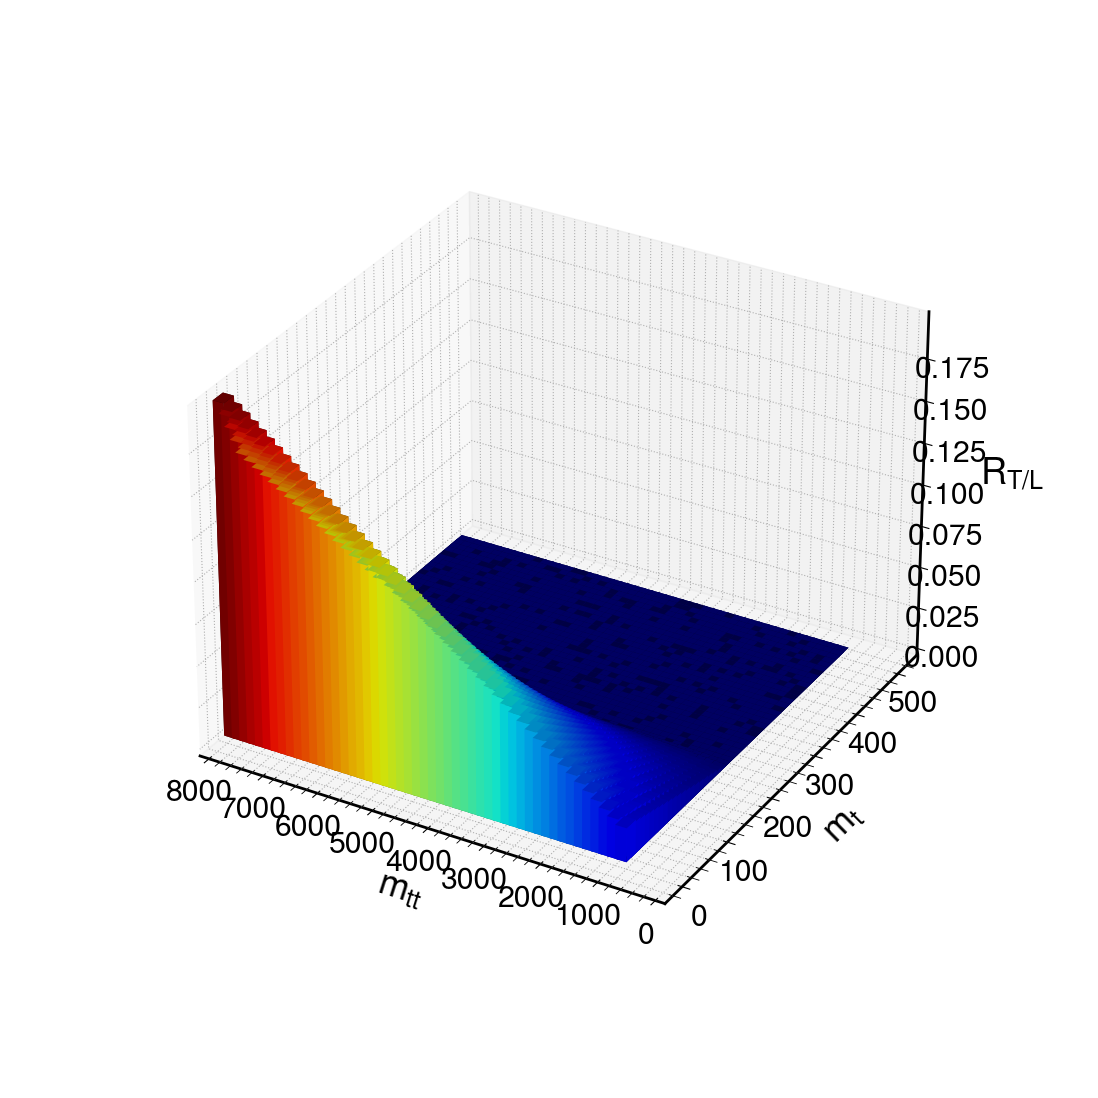

In [18]:
fig = plt.figure(figsize=(15, 14))
ax1 = fig.add_subplot(projection='3d')

x = mtt.flatten()#f_mtt
y = mt.flatten()#f_mt

z = f_rtl.flatten()
z = np.where(z < 0, 0, z)

bottom = np.zeros_like(z) #mtt_vs_mt.values()[1]

dx = 200
dy = 20

cmap = plt.cm.get_cmap('jet')
hmax = np.max(z)
hmin = np.min(z)

# hmin = 0.0
# hmax = 0.05
rgba = [cmap((k-hmin)/hmax) for k in z] 

ax1.bar3d(x, y, bottom, dx, dy, z, color=rgba)#, zorder=0)
ax1.set_xlim(8000,0)
# ax1.set_zlim(0.01,0.12)

ax1.zaxis.set_rotate_label(False)
ax1.set_xlabel(r'$m_{tt}$', labelpad=20, loc='right')
ax1.set_ylabel(r'$m_t$', labelpad=20)
ax1.set_zlabel(r'$R_{T/L}$', labelpad=30)#, loc='top')#, rotation=180)

ax1.dist = 13

plt.show()


In [19]:
print('p0 {0:0.2e}'.format(p0))
print('p1 {0:0.2e}'.format(p1))
print('p2 {0:0.2e}'.format(p2))
print('p3 {0:0.2e}'.format(p3))
print('p4 {0:0.2e}'.format(p4))
print('p5 {0:0.2e}'.format(p5))


p0 6.45e-02
p1 2.57e-04
p2 5.17e-02
p3 -2.59e-04
p4 9.56e-08
p5 4.89e-04


# Transfer Function + Mistag Rate

/opt/conda/lib/python3.8/site-packages/hist/basehist.py:324: UserWarning: List indexing selection is experimental. Removed bins are not placed in overflow.
  return super().__getitem__(self._index_transform(index))
/opt/conda/lib/python3.8/site-packages/boost_histogram/_internal/view.py:190: RuntimeWarning: invalid value encountered in divide
  ufunc(
/opt/conda/lib/python3.8/site-packages/boost_histogram/_internal/view.py:196: RuntimeWarning: invalid value encountered in divide
  ufunc(


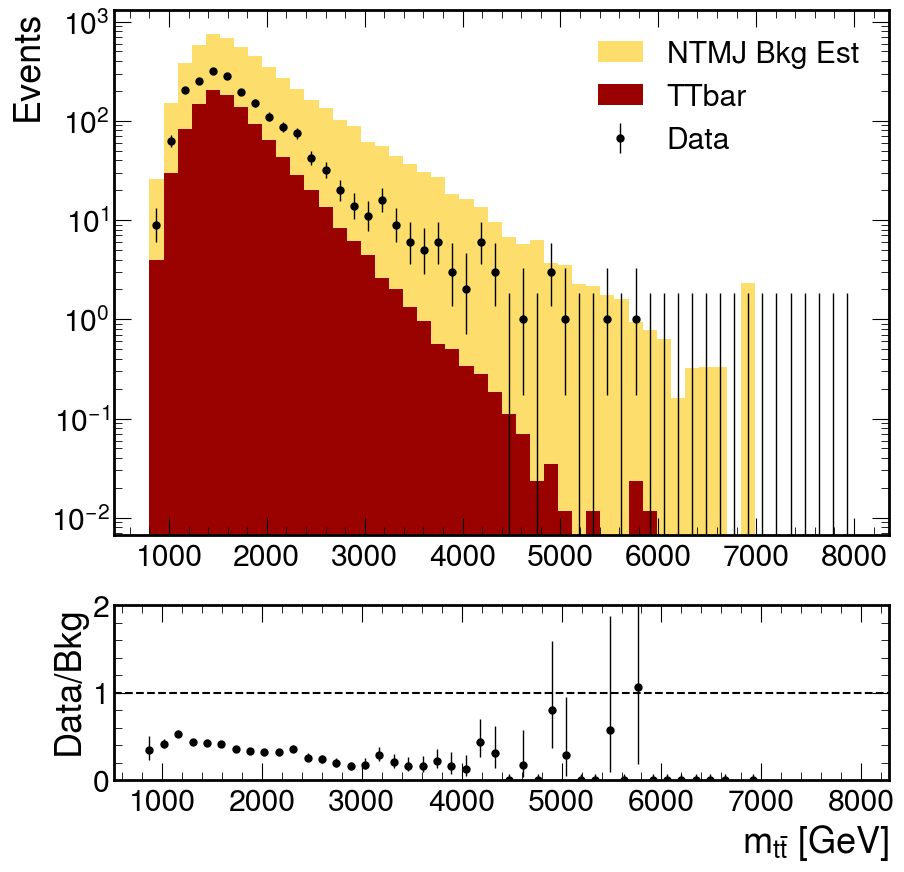

In [45]:
fig, (ax1, ax2) = plt.subplots(nrows=2, height_ratios=[3, 1])


bins = hbkg_mtt.axes['ttbarmass'].edges[:-1]


IOV = '2016'

httbar = getHist('ttbarmass', 'TTbar', False, IOV, sum_axes=['anacat','systematic'], integrate_axes={'anacat':signal_cats})
hntmj  = getHist('ttbarmass', 'JetHT', False, IOV, sum_axes=['anacat','systematic'], integrate_axes={'anacat':pretag_cats})
hdata  = getHist('ttbarmass', 'JetHT', False, IOV, sum_axes=['anacat','systematic'], integrate_axes={'anacat':signal_cats})




hntmj  = getHist('ttbarmass', 'JetHT', False, IOV, sum_axes=['anacat','systematic'], integrate_axes={'anacat':pretag_cats})

h_mtt_mt = getHist('mtt_vs_mt', 'JetHT', False, IOV, sum_axes=['anacat'], integrate_axes={'anacat':pretag_cats})
# hntmj_2d = h_mtt_mt * np.abs(f_rtl) * np.abs(f_rlf)
hntmj_2d = h_mtt_mt * np.abs(f_rlf)
hntmj = hntmj_2d[{'jetmass':sum}]


# hbkg_mr = bkg['ttbarmass'][{'anacat':antitag_cats}][{'anacat':sum,''}] * qcdsf#* qcdsf['bkg']



h2 = httbar + hntmj# * np.abs(np.average(f_rtl, axis=0)) #* np.abs(np.average(f_rlf, axis=1))





hep.histplot(hdata, histtype='errorbar', color='k', ax=ax1, label='Data')
ax1.set_yscale('log')
# ax1.plot(bins, h2, ls='', marker='o')
hep.histplot(h2, histtype='fill', color='xkcd:pale gold', label='NTMJ Bkg Est', ax=ax1)
hep.histplot(httbar, histtype='fill', color='xkcd:deep red', label='TTbar', ax=ax1)


# hep.histplot(hbkg_mtt, histtype='errorbar', color='g', label='QCD Bkg Est', ax=ax1)



# hep.histplot(hbkg_mtt, histtype='errorbar', color='g', ax=ax1)

ax1.set_ylabel('Events')

ratio_plot = hdata / h2.values()


# # ratio_plot =  values / fitted
# # yerr = ratio_plot * np.sqrt(1/values + 1/fitted)

hep.histplot(ratio_plot, ax=ax2, histtype='errorbar', color='black')
ax2.set_ylim(0,2)
ax2.axhline(1, color='black', ls='--')
ax2.set_ylabel('Data/Bkg')
ax2.set_xlabel(ax1.get_xlabel())
ax1.set_xlabel('')


ax1.legend(loc=1)


# ax1.set_ylim(1e2,1e4)

In [22]:
def getHist(hname, ds, bkgest, year, sum_axes=['anacat'], integrate_axes={}):
    
    ######################################################################################
    # hname = histogram name (example: 'ttbarmass')                                      #
    # ds = dataset name (example: 'JetHT')                                               #
    # bkgest = boolean, True if bkg estimate applied                                     #
    # year = '2016APV' or '2016' or '2017' or '2018'                                     #
    # sum_axes = names of axes to sum over for scikit-hep/hist histogram                 #
    # integrate_axes = range to integrate over axis (example: {'anacat': [0,1,2,3,4,5]}) #
    ######################################################################################    

    
    # load histograms and get scale factors
    coffeaFiles = getCoffeaFilenames()
    
    cfiles = []
    sf = []
    bkgest_str = np.where([bkgest], 'weighted', 'unweighted')[0]
    
    for key, file in coffeaFiles[ds][bkgest_str][year].items():
        loaded_file = util.load(file)
        cfiles.append(loaded_file)
        
        if 'TTbar' in ds and '700to1000' in key:
            sf.append(lumi[year] * ttbar_xs1 * toptag_sf**2 / loaded_file['cutflow']['sumw'])
        elif 'TTbar' in ds and '1000toInf' in key:
            sf.append(lumi[year] * ttbar_xs2 * toptag_sf**2 / loaded_file['cutflow']['sumw'])     
        elif 'QCD' in ds:
            sf.append(lumi[IOV] * qcd_xs / loaded_file['cutflow']['sumw'])  
        else:
            sf.append(1.)
    
    # sum or integrate axes for all hists from dataset eras or pt bins
    sum_axes_dict = {ax:sum for ax in sum_axes}
    
    hists = []
    for cfile in cfiles:
            hists.append(cfile[hname][integrate_axes][sum_axes_dict])
    
    
    # sum all hists from dataset eras or pt bins
    histo = hists[0]*sf[0]
    if len(hists) > 1:
        for i in range(len(hists) - 1): 
            histo = histo + hists[i+1]*sf[i+1]
            
            
    
    return histo
    
            
            
def plotBackgroundEstimate(hdata, hntmj, httbar, year, text=''):
    
    hbkg = hntmj + httbar
    
    fig, (ax1, ax2) = plt.subplots(nrows=2, height_ratios=[3, 1])

    
    hep.cms.label('', data=True, lumi='{0:0.1f}'.format(lumi[year]/1000.), year=year, loc=2, fontsize=20, ax=ax1)
    hep.cms.text(text, loc=2, fontsize=20, ax=ax1)

    hep.histplot(hdata,  ax=ax1, histtype='errorbar', color='black', label='Data')
    hep.histplot(hbkg,   ax=ax1, histtype='fill', color='xkcd:pale gold', label='NTMJ')
    hep.histplot(httbar, ax=ax1, histtype='fill', color='xkcd:deep red', label='TTbar')


    ratio_plot =  hdata / hbkg.values()
    hep.histplot(ratio_plot, ax=ax2, histtype='errorbar', color='black')
    ax2.set_ylim(0,2)
    ax2.axhline(1, color='black', ls='--')
    ax2.set_ylabel('Data/Bkg')

    ax1.legend()
    ax1.set_yscale('log')
    ax1.set_ylabel('Events')
    ax1.set_xlabel('')
    ax1.set_ylim(1e-1, 1e5)
    ax1.set_xlim(900, 6000)
    ax2.set_xlim(900, 6000)            
    

    

    